#   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> ARIMA

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt

from   statsmodels.tsa.arima.model         import  ARIMA                # ARIMA
from   statsmodels.tsa.statespace.sarimax  import SARIMAX               # Seasonal ARIMA

from   statsmodels.tsa.holtwinters         import ExponentialSmoothing  # Exponential Smoothing
from   statsmodels.tsa.vector_ar.var_model import VAR                   # Vector Autoregression

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Reading TimeSeries

In [2]:
# Serie
Serie = [ (100*np.sin(2*x)+150*np.sin(3*x))/(2+np.sin(5*x)) for x in range(0,1000)]

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Trend-Stationary Tests
 - **Augmented Dickey-Fuller Unit Root Test**
 - **Kwiatkowski-Phillips-Schmidt-Shin Test**

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Augmented Dickey-Fuller Unit Root Test
 - Tests whether a **time series** has a **unit root**, e.g. has a **trend** or more generally is **autoregressive**.

In [3]:
from statsmodels.tsa.stattools import adfuller

print("\n\nAugmented Dickey-Fuller Unit Root Test") 
stat, p, lags, obs, crit, t = adfuller( Serie )

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')
else: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')



Augmented Dickey-Fuller Unit Root Test
stat=-47.808, p=0.000
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Kwiatkowski-Phillips-Schmidt-Shin Test
 - Tests whether a **time series** is **trend stationary or not**

In [4]:
from statsmodels.tsa.stattools import kpss
print("\nKwiatkowski-Phillips-Schmidt-Shin Test")  
stat, p, lags, crit = kpss( Serie )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')
else: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')


Kwiatkowski-Phillips-Schmidt-Shin Test
stat=0.015, p=0.100
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Training Set

In [5]:
# Split the series into training and prediction data
train = Serie

##   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Models

In [6]:
# ARIMA 
arima = ARIMA(
    endog                  =  train,
    order                  = (10,0,5),
    seasonal_order         = (0, 0, 0, 0),
    trend_offset           =  1,
    trend                  =  None,
    exog                   =  None,
    dates                  =  None,
    freq                   =  None,
    enforce_stationarity   =  True,
    enforce_invertibility  =  True,
    validate_specification =  True,
    concentrate_scale      =  False,
    missing                = 'none'
)

# SARIMAX
sarimax = SARIMAX(
    endog                  =  train,
    order                  = (10,0,5),
    seasonal_order         = (0, 0, 0, 0),
    trend_offset           =  1,
    trend                  =  None,
    exog                   =  None,
    dates                  =  None,
    freq                   =  None,
    enforce_stationarity   =  True,
    enforce_invertibility  =  True,
    validate_specification =  True,
    concentrate_scale      =  False,
    missing                = 'none'
)

# ExponentialSmoothing
ExpS = ExponentialSmoothing(
    endog                  =  train,
    trend                  =  None,
    seasonal               =  None, 
    seasonal_periods       =  None,
    initial_level          =  None,
    initial_trend          =  None,
    initial_seasonal       =  None,
    bounds                 =  None,
    dates                  =  None,
    freq                   =  None,
    damped_trend           =  False,
    use_boxcox             =  False,
    initialization_method  = 'estimated',
    missing                = 'none'
)

## 
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Fitting

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:              SARIMAX(10, 0, 5)   Log Likelihood               -1578.203
Date:                Thu, 30 Nov 2023   AIC                           3188.407
Time:                        22:31:15   BIC                           3266.931
Sample:                             0   HQIC                          3218.251
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1626      0.013     12.190      0.000       0.136       0.189
ar.L2          0.0774      0.012      6.197      0.000       0.053       0.102
ar.L3          0.0951      0.011      8.972      0.0

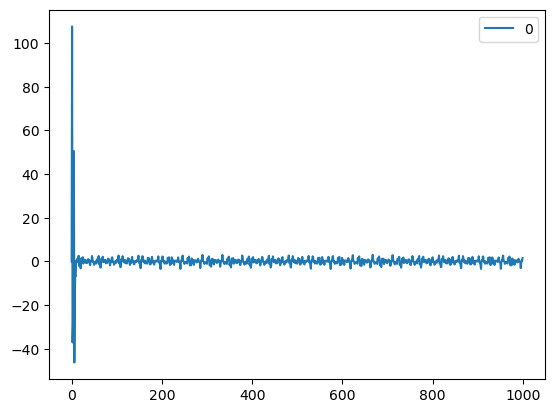

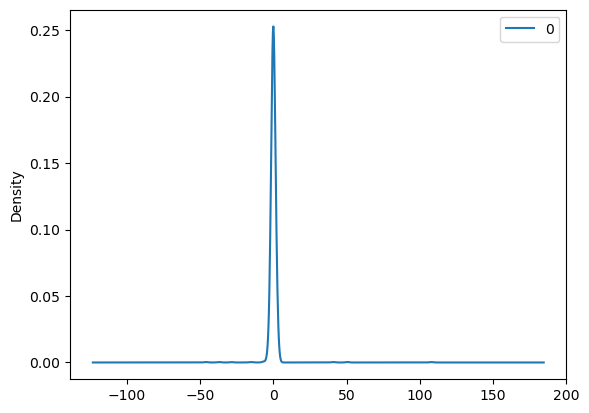

                 0
count  1000.000000
mean      0.060306
std       4.660287
min     -46.322809
25%      -0.696054
50%      -0.031387
75%       0.612014
max     107.674919


In [7]:
# fitted model
model = sarimax.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

## 
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Forcasting Future n Steps

In [8]:
# forcasting
n    =   50
PRED = model.forecast(steps=n)
TRUE = [ (100*np.sin(2*x)+150*np.sin(3*x))/(2+np.sin(5*x)) for x in range(1000,1000+n,1)]
RMSE = (np.sum((TRUE - PRED)**2)/n)**0.5
RMSE

4.832588442976758

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Visualizing The Forcast

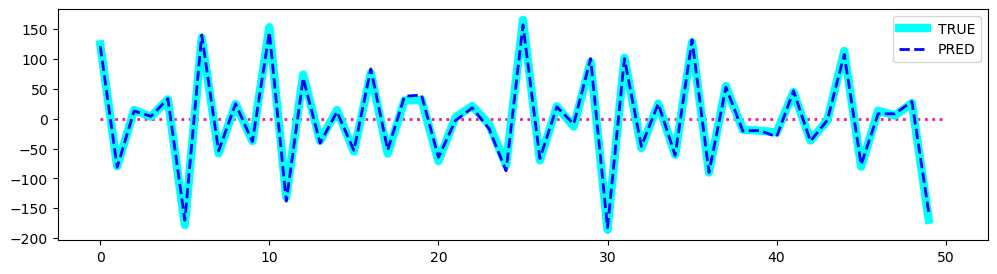

In [9]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot(  [0,n]   , [0,0] , ":"  ,                color='deeppink' ,linewidth=2 )
plt.plot( range(n) , TRUE  , "-"  , label="TRUE" , color='cyan'     ,linewidth=6 )
plt.plot( range(n) , PRED  , "--" , label="PRED" , color='blue'     ,linewidth=2 )
plt.legend(); plt.show()

#####   

#####   